<img src="img/banner.jpg">

# Marvel's Superheroes

Mar Lizana
<br>
Data Analytics PT 2020
<br>
Ironhack

## Introducción

### Motivación

El principal objetivo de la selección de este dataset es observar los subconjuntos que se forman dentro de los diferentes personajes de Marvel en los cómics.
El multiverso Marvel hace referencia a la existencia de varios universos con sus propias características en una misma línea temporal.

### Dataset

## Preparar los datasets, examinar y analizar

### Librerías

In [1]:
import numpy as np
import pandas as pd
import random
import re
from math import pi
from sklearn.preprocessing import MinMaxScaler


#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#Grafo
import networkx as nx 
import plotly.graph_objects as go
import plotly.express as px
import itertools


#Interactivo
import altair
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interact_manual

#De lista de tuplas a dict
from collections import defaultdict

In [2]:
plt.rcParams["figure.figsize"] = (15,10)

### Importamos los datasets:

In [3]:
#Usaremos este dataset para el apartado de análisis estadístico y visualización.
character_stats = pd.read_csv("marvel-superheroes/charcters_stats.csv")
character_info = pd.read_csv("marvel-superheroes/marvel_characters_info.csv")

#Este segundo dataset será contruido para poder elaborar el grafo final.
marvel_charanther = pd.read_csv("marvel-superheroes/characters.csv")
marvel_comics = pd.read_csv("marvel-superheroes/charactersToComics.csv")
comics = pd.read_csv("marvel-superheroes/comics.csv")

Los unimos para poder trabajar con toda la información:

In [4]:
marvel_graph = pd.merge(marvel_charanther, marvel_comics, on='characterID')
marvel_graph = pd.merge(marvel_graph, comics, on = "comicID")


marvel_stats = pd.merge(character_stats,character_info, on= "Name")

### Marvel Stats

In [5]:
marvel_stats.head()

,Name,Alignment_x,Intelligence,Strength,Speed,Durability,Power,Combat,Total,ID,Alignment_y,Gender,EyeColor,Race,HairColor,Publisher,SkinColor,Height,Weight
0,A-Bomb,good,38,100,17,80,17,64,316,0,good,Male,yellow,Human,No Hair,Marvel Comics,-,203.0,441.0
1,Abe Sapien,good,88,14,35,42,35,85,299,1,good,Male,blue,Icthyo Sapien,No Hair,Dark Horse Comics,blue,191.0,65.0
2,Abin Sur,good,50,90,53,64,84,65,406,2,good,Male,blue,Ungaran,No Hair,DC Comics,red,185.0,90.0
3,Abomination,bad,63,80,53,90,55,95,436,3,bad,Male,green,Human / Radiation,No Hair,Marvel Comics,-,203.0,441.0
4,Abraxas,bad,88,100,83,99,100,56,526,4,bad,Male,blue,Cosmic Entity,Black,Marvel Comics,-,-99.0,-99.0


In [6]:
marvel_stats.shape

(600, 19)

Con esta información podemos concluir que nuestra base de datos contiene registros de un total de 600 superhéroes.

In [7]:
marvel_stats.isnull().sum()

Name            0
Alignment_x     3
Intelligence    0
Strength        0
Speed           0
Durability      0
Power           0
Combat          0
Total           0
ID              0
Alignment_y     0
Gender          0
EyeColor        0
Race            0
HairColor       0
Publisher       7
SkinColor       0
Height          0
Weight          0
dtype: int64

In [8]:
pd.unique(marvel_stats['Publisher'])

array(['Marvel Comics', 'Dark Horse Comics', 'DC Comics', 'NBC - Heroes',
       'Wildstorm', 'Image Comics', nan, 'Icon Comics', 'SyFy',
       'Hanna-Barbera', 'Team Epic TV', 'HarperCollins', 'ABC Studios',
       'Universal Studios', 'Shueisha', 'Sony Pictures', 'Microsoft'],
      dtype=object)

Borro todos los héroes que no sean de Marvel

In [9]:
marvel_stats = marvel_stats.drop(marvel_stats[marvel_stats['Publisher']!='Marvel Comics'].index)
marvel_stats.shape

(349, 19)

Y elimino los posibles duplicados por multiverso.

In [10]:
marvel_stats= marvel_stats.drop_duplicates(['Name'], keep='first')
marvel_stats.shape

(338, 19)

### Marvel Graph

In [11]:
marvel_graph.head()

,characterID,name,comicID,title,issueNumber,description
0,1009220,Captain America,16232,Cap Transport (2005) #12,12.0,NaN
1,1010740,Winter Soldier,16232,Cap Transport (2005) #12,12.0,NaN
2,1009220,Captain America,16248,Cap Transport (2005) #9,9.0,NaN
3,1009471,Nick Fury,16248,Cap Transport (2005) #9,9.0,NaN
4,1009552,S.H.I.E.L.D.,16248,Cap Transport (2005) #9,9.0,NaN


In [12]:
marvel_graph.shape

(82185, 6)

In [13]:
marvel_graph.isnull().sum()

characterID        0
name               0
comicID            0
title              0
issueNumber        0
description    26479
dtype: int64

Extraer el año de la columna título puede resultar interesante para la posterior visualización.

In [14]:
years = [",".join(re.findall("\d{4}", i)) for i in marvel_graph['title']]
marvel_graph['Year']=years

Hay años futuros... y años previos a la creación de los comics... Intentaremos usar esta información igualmente por probar.

## Análisis estadístico y visualización

### Correlación entre variables

Haremos una primera visualización de la información con un gráfico interactivo de correlación entre habilidades de superhéroes:

In [15]:
def make_plot(x, y): 
    sns.jointplot(x=x,y=y, data=marvel_stats,kind="reg", color = "r")
marvel_num_col=['Intelligence','Strength','Speed','Durability','Power','Combat',
               'Total','Height','Weight']
c = interact(make_plot, x = marvel_num_col, y = marvel_num_col)

interactive(children=(Dropdown(description='x', options=('Intelligence', 'Strength', 'Speed', 'Durability', 'P…

### SpiderGraph por súper héroe

Necesitamos estandarizar los parámetros dentro de un rango determinado para que los que sean más altos no predominen sobre el resto.

In [16]:
#Estandarización de valores:
df = marvel_stats[['Intelligence','Strength','Speed','Durability','Power','Combat','Height','Weight']]
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=['Intelligence','Strength','Speed','Durability','Power','Combat',
               'Height','Weight'])

In [17]:
scaled_df['Name'] = [name for name in marvel_stats['Name']]

In [18]:
#Pasamos los nombres a índice para poder realizar la búsqueda:
scaled_df = scaled_df.set_index(scaled_df['Name'])

In [19]:
@interact(Heroe1='')

def spiderplot(Heroe1):
    
    try:
        categories=list(scaled_df)[:-1]
        N = len(categories)

        values=scaled_df.loc[Heroe1].drop('Name').values.flatten().tolist()

        values += values[:1]

        # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]

        # Initialise the spider plot
        ax = plt.subplot(111, polar=True)
        ax.set_title(Heroe1)

        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], categories, color='black', size=8)

        # Plot data
        ax.plot(angles, values, color = "red", linewidth=1, linestyle='solid')

        # Fill area
        ax.fill(angles, values, 'r', alpha=0.1)
    
    except KeyError:
        print("Esperando un nombre...")


interactive(children=(Text(value='', description='Heroe1'), Output()), _dom_classes=('widget-interact',))

### Cajas y bigotes por Género y Alignment

In [20]:
@interact
def eda(Hability = ['Intelligence','Strength','Speed','Durability','Power','Combat']):
    sns.catplot(x='Alignment_x', y=Hability, data=marvel_stats, hue='Gender',palette="Reds", kind="box")

interactive(children=(Dropdown(description='Hability', options=('Intelligence', 'Strength', 'Speed', 'Durabili…

## Grafo

### Observación

Hacemos una primera observación de como queda el dataset con el que trabajaremos.

In [21]:
marvel_graph.head()

,characterID,name,comicID,title,issueNumber,description,Year
0,1009220,Captain America,16232,Cap Transport (2005) #12,12.0,NaN,2005
1,1010740,Winter Soldier,16232,Cap Transport (2005) #12,12.0,NaN,2005
2,1009220,Captain America,16248,Cap Transport (2005) #9,9.0,NaN,2005
3,1009471,Nick Fury,16248,Cap Transport (2005) #9,9.0,NaN,2005
4,1009552,S.H.I.E.L.D.,16248,Cap Transport (2005) #9,9.0,NaN,2005


In [22]:
marvel_graph['name'].value_counts()

Spider-Man         3483
X-Men              3297
Iron Man           2620
Wolverine          2399
Captain America    2240
                   ... 
Talos                 1
Preak                 1
Nakia (Nakia)         1
Red Shift             1
Stephen Strange       1
Name: name, Length: 1169, dtype: int64

Gracias a las función <CODE>pivot_table</CODE> podemos empezar a hacernos una idea real de los personajes que puede haber por comic.

In [23]:
comicID_name=pd.DataFrame(marvel_graph.pivot_table(index = ["comicID", "name"]))
#Hago un head para evitaros el scrolldown...pero creedme que se ve.
comicID_name.head()

characterID  issueNumber
comicID name                                     
2       Captain America    1009220.0          6.0
        Danny Rand         1010776.0          6.0
        Jessica Jones      1009378.0          6.0
        Logan              1010363.0          6.0
        Luke Cage          1009215.0          6.0

### Obtención de la estructura de datos necesarea.

Y ahora es cuando empieza lo divertido:
1. Creamos tuplas con la relación <CODE>'comicID'</CODE>, <CODE>'name'</CODE>.
2. Con estas tuplas y la función <CODE>setdefault</CODE> pasada a los elementos de la lista de tuplas conseguimos un diccionario donde las llaves son los <CODE>'comicID'</CODE> y los valores los distintos <CODE>'name'</CODE> relacionados.
3. Aplicaremos la función <CODE>combinations</CODE> para obtener todas las permutaciones que hay dentro de cada comic.

In [24]:
#Con esto obtenemos la lista de tuplas
lst = []
for i in range(0, len(marvel_graph["comicID"])):
    d = (marvel_graph["comicID"][i],marvel_graph["name"][i])
    lst.append(d)

In [25]:
#Pasamos a diccionario
d = {}
for k, v in lst:
    d.setdefault(k, []).append(v)

In [26]:
#Nos quedamos solo con los valores del diccionario porque no nos interesa que aparezcan las llaves.
comic_persons = d.values()

In [27]:
#Creamos las permutaciones
lst = []
for i in comic_persons:
    lst.append(list(itertools.combinations(i, 2)))

In [28]:
#Por último sacamos las tuplas de las listas para obtener solo una lista de tuplas y no una lista
#de listas de tuplas.
total_relationships=[]
for i in lst:
    for e in i:
        total_relationships.append(e)

### Generando el grafo

Con este primer grafo vemos todas las relaciones de un superheroe

In [29]:
@interact(Heroe='')

def graph_select(Heroe):

    selection_relationships = []
    
    for couple in total_relationships:
        for name in couple:
            if name ==  Heroe:
                selection_relationships.append(couple)
                    
    G=nx.Graph(notebook = True)
    G.add_edges_from(selection_relationships[:50])
    nx.draw(G, with_labels=True, node_color='r', node_size = 800, edge_color='r')

interactive(children=(Text(value='', description='Heroe'), Output()), _dom_classes=('widget-interact',))

Y con este las relaciones entre los superheroes

In [35]:
G=nx.Graph(notebook = True)

In [36]:
G.add_edges_from(total_relationships[:1500])

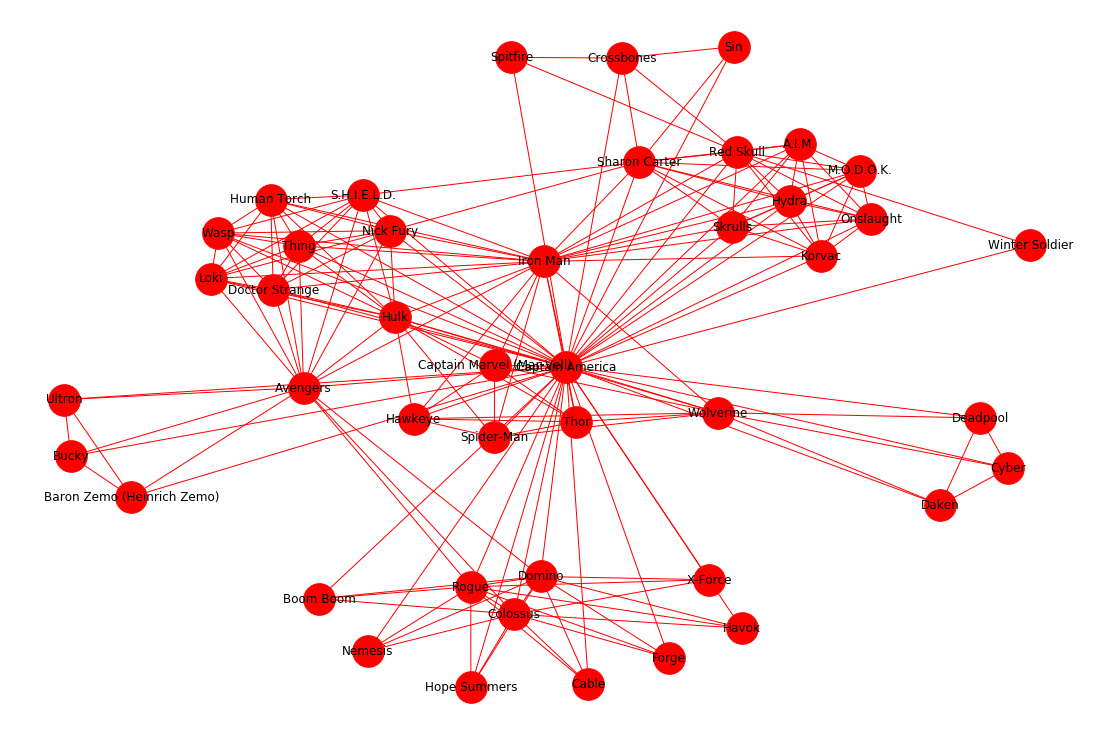

In [37]:
nx.draw(G, with_labels=True, node_color="r", node_size=1000, edge_color = "r")